In [ ]:
import pandas as pd
df = pd.read_csv('./course-catalog.csv')

# Drop unnecessary columns
# We only need the Subject, Number, Description
df =df[['Subject', 'Number', 'Description']]
# Drop duplicates
df = df.drop_duplicates()
#fill NaN values with empty string
df = df.fillna('')
df.head(10)


In [ ]:
#remove punctuation and numbers, lowercase
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# lowercase
df['Description'] = df['Description'].apply(lambda x: x.lower())
# remove punctuation and numbers
df['Description'] = df['Description'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))
df.head(10)

In [ ]:
#nltk.download('stopwords')
#nltk.download('punkt')
catalog_stopwords = stopwords.words('english')
# add custom stopwords for course descriptions
catalog_stopwords.extend(['see', 'prerequisite', 'hour', 'hours', 'freshman', 'sophomore', 'junior', 'senior', 'standing', 'credit', 'consent', 'equivalent', 'undergraduate', 'graduate', \
                           'may', 'taken', 'course', 'courses', 'students', 'student', 'topics', 'include', 'includes', 'including', 'introduction', 'repeated', 'intended', \
                            'su', 'eps', 'instructor', 'section', 'one', 'vary', 'maximum', 'degree', 'program', 'department', 'register', 'per', 'term', 'terms', 'registration', \
                            'completed', 'concurrently', 'enrolled', 'enrollment', 'approved', 'letter', 'grading', 'major', 'majors', 'fees', 'apply', 'illinois', 'andor', \
                            'summer', 'carle', 'concurrent', 'class', 'week', 'semester', 'semesters', 'required', 'using', 'examine', 'examines', 'restricted', 'phase', 'separate', \
                            'use', 'departmental', 'approval', 'offered', 'years', 'college', 'must', 'given', 'faculty', 'new', 'prerequisites', 'areas', 'offerings', 'schedule', 'level'])
# should add each subject as a stopword since they are mentioned in the descriptions
for subject in df['Subject'].unique():
    catalog_stopwords.append(subject.lower())
# show stopwords
print(catalog_stopwords)
df.head(10)

In [ ]:

def remove_stopwords(description):
    # Tokenize the description
    tokens = word_tokenize(description)
    # Remove stopwords 
    filtered_tokens = [word for word in tokens if word not in catalog_stopwords]
    # Rejoin the filtered tokens into a string
    filtered_description = ' '.join(filtered_tokens)
    return filtered_description

# Apply the cleaning function to each description
df['Description'] = df['Description'].apply(remove_stopwords)


# remove rows with empty descriptions now that we have removed stopwords
df = df[df['Description'] != '']

# save cleaned data
df.to_csv('./cleaned-catalog.csv', index=False)

In [ ]:
# wordcloud
from wordcloud import WordCloud
long_string = ' '.join(df['Description'])
wordcloud = WordCloud(width=2000, height=1400, background_color='white').generate(long_string)
wordcloud.to_file('wordcloud.png')


In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Latent Dirichlet Allocation (LDA) Model using scikit-learn
data = pd.read_csv('./cleaned-catalog.csv')
# Create a CountVectorizer for LDA
count_vectorizer = CountVectorizer(stop_words=catalog_stopwords, max_df=0.95, min_df=2)
count_data = count_vectorizer.fit_transform(data['Description'])

n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, random_state=1000)
lda.fit(count_data)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, count_vectorizer.get_feature_names_out(), no_top_words)


Topic 0:
professional skills business experience learning development work provides knowledge activities
Topic 1:
current topic special research professional food seminar discussion interest study
Topic 2:
dance theory development contemporary business techniques practice leadership physical methods
Topic 3:
music applied audition performance prior completion instruction jazz chemistry additional
Topic 4:
social health issues human development education political field public systems
Topic 5:
systems theory engineering design analysis control techniques applications processes problems
Topic 6:
design research work study individual honors additional thesis media project
Topic 7:
language writing research advanced study reading education professional teaching english
Topic 8:
data analysis methods learning techniques statistical models programming concepts science
Topic 9:
professional research management medicine curriculum successful knowledge clinical problems work


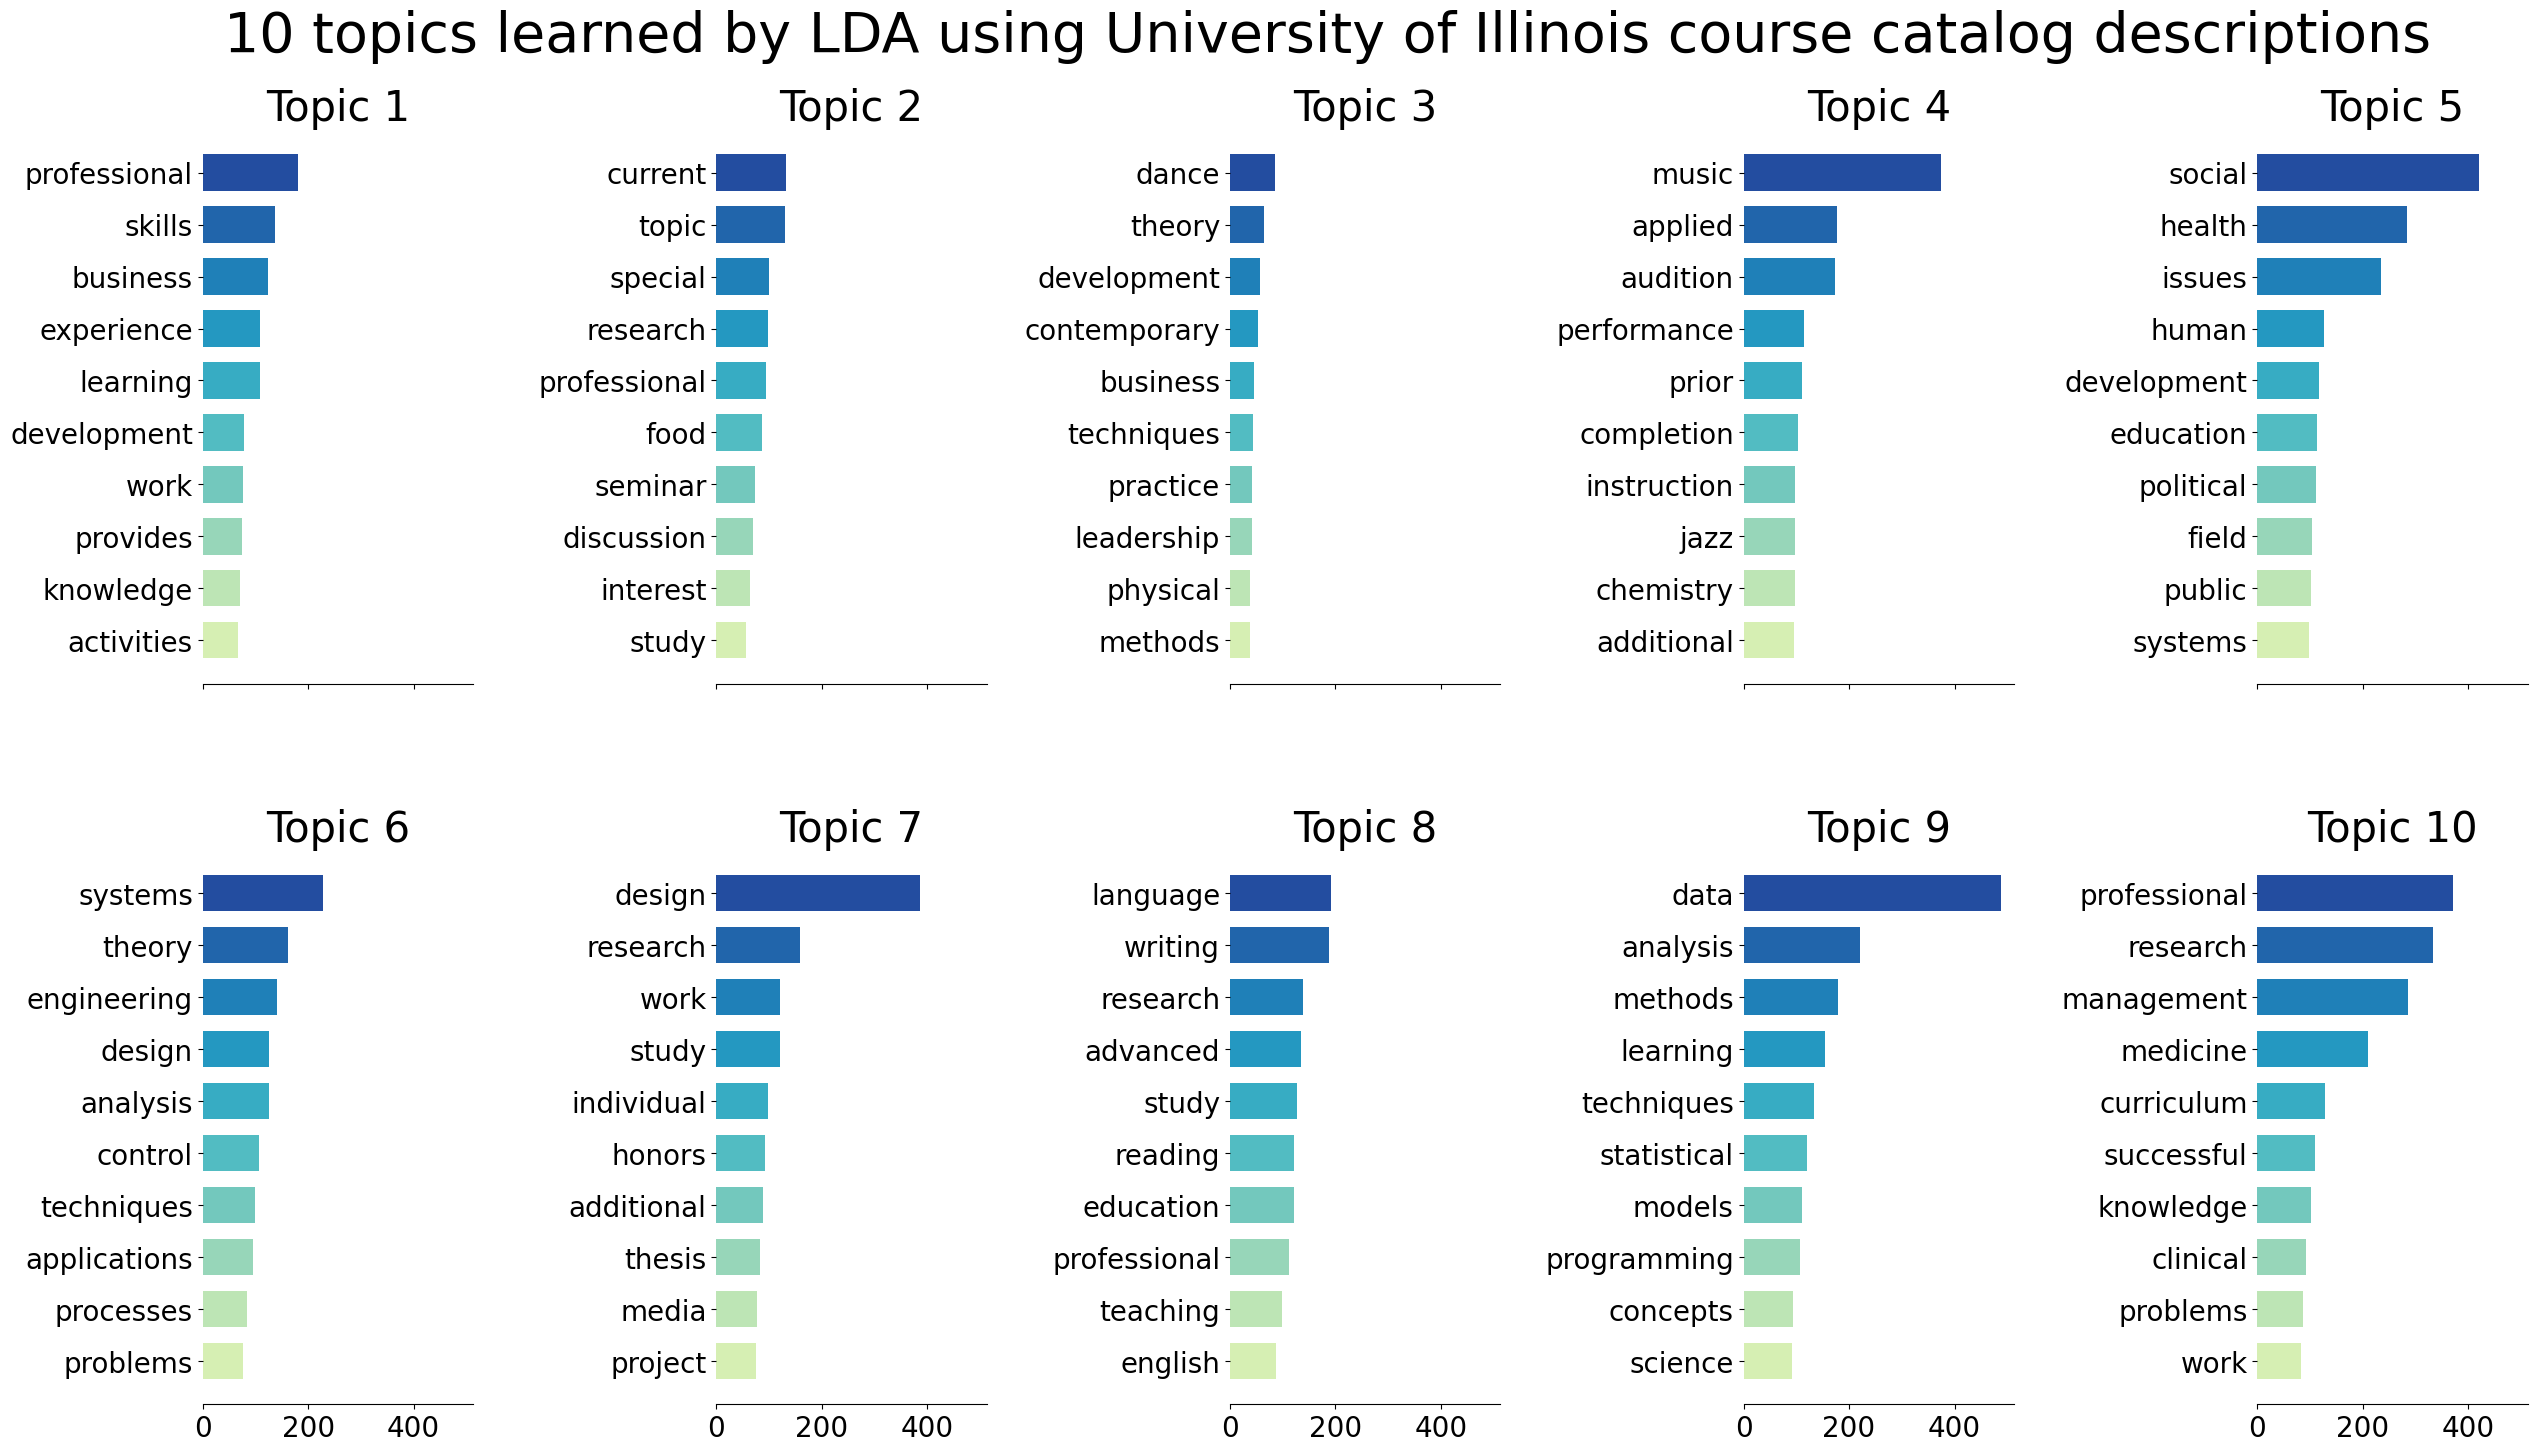

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import random
colormaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    color = random.choice(colormaps)
    colors = plt.get_cmap(color)(np.linspace(0.2, 0.8, n_top_words))
    # reverse the color map so that the first topic is the darkest
    # colors = colors[::-1]

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color=colors)  # Specify the colors for each bar
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(lda, count_vectorizer.get_feature_names_out(), no_top_words, f'{no_top_words} topics learned by LDA using University of Illinois course catalog descriptions')

In [ ]:
# Make a new csv for each subject for topic modeling by department (subject)
# for subject in df['Subject'].unique():
#     subject_df = df[df['Subject'] == subject]
#     print(subject_df)